In [1]:
from pyHalo.PresetModels.cdm import CDM
from pyHalo.PresetModels.wdm import WDM
from pyHalo.plotting_routines import *
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from copy import deepcopy
from pyHalo.truncation_models import truncation_models
from pyHalo.single_realization import Realization

np.random.seed(111)

### Tidal evolution in pyHalo

The most accurate tidal truncation model implemented in pyHalo is the one presented by https://ui.adsabs.harvard.edu/abs/2025arXiv250307728D/abstract

This is an empirical model that predicts bound masses from the properties (concentration, infall time) of subhalos at infall. The code then calculates the density profile of subhalos from the bound mass using tidal tracks.

In [2]:
sigma_sub = 0.3
log_10_half_mode_mass = 7.5

cdm_truncation_galacticus = CDM(0.5, 1.5, sigma_sub=sigma_sub, LOS_normalization=0.0, 
         truncation_model_subhalos='TRUNCATION_GALACTICUS')
wdm_truncation_galacticus = WDM(0.5, 1.5, sigma_sub=sigma_sub, LOS_normalization=0.0, 
                                       log_mc=log_10_half_mode_mass,
                               truncation_model_subhalos='TRUNCATION_GALACTICUS')

lens_cosmo = cdm_truncation_galacticus.lens_cosmo


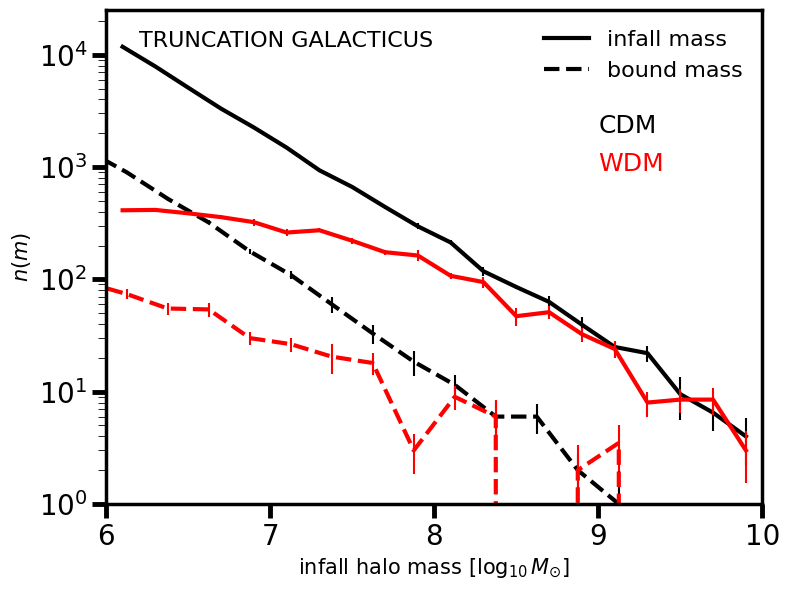

In [3]:
fig = plt.figure(1)
ax = plt.subplot(111)
fig.set_size_inches(8, 6)
kwargs_plot={'lw':3, 'label': 'infall mass'}
plot_subhalo_mass_functon(cdm_truncation_galacticus, log_m_low=6.0, log_m_high=10.0, bound_mass_function=False, nbins=20,
                                  n_bootstrap=10, ax=ax, kwargs_plot=kwargs_plot, color='k')
kwargs_plot={'linestyle': '--', 'lw':3, 'label': 'bound mass'}
plot_subhalo_mass_functon(cdm_truncation_galacticus, log_m_low=5.0, log_m_high=10.0, bound_mass_function=True, nbins=20,
                                  n_bootstrap=10, ax=ax, kwargs_plot=kwargs_plot, color='k')

kwargs_plot={'lw':3}
plot_subhalo_mass_functon(wdm_truncation_galacticus, log_m_low=6.0, log_m_high=10.0, bound_mass_function=False, nbins=20,
                                  n_bootstrap=10, ax=ax, kwargs_plot=kwargs_plot, color='r')
kwargs_plot={'linestyle': '--', 'lw':3}
plot_subhalo_mass_functon(wdm_truncation_galacticus, log_m_low=5.0, log_m_high=10.0, bound_mass_function=True, nbins=20,
                                  n_bootstrap=10, ax=ax, kwargs_plot=kwargs_plot, color='r')

plt.annotate('CDM', fontsize=18, color='k', xy=(0.75, 0.75), xycoords='axes fraction')
plt.annotate('WDM', fontsize=18, color='r', xy=(0.75, 0.675), xycoords='axes fraction')
plt.annotate('TRUNCATION GALACTICUS', xy=(0.05, 0.925), xycoords='axes fraction', color='k', fontsize=16)
plt.legend(fontsize=16, frameon=False)
plt.xlim(6, 10.0)
plt.ylim(1.0, 25000)
plt.tight_layout()


(array([0.30855339, 0.31142365, 0.33438576, 0.30568312, 0.31429392,
        0.23536165, 0.24397245, 0.19804822, 0.19374282, 0.05453502]),
 array([-4. , -3.6, -3.2, -2.8, -2.4, -2. , -1.6, -1.2, -0.8, -0.4,  0. ]),
 <BarContainer object of 10 artists>)

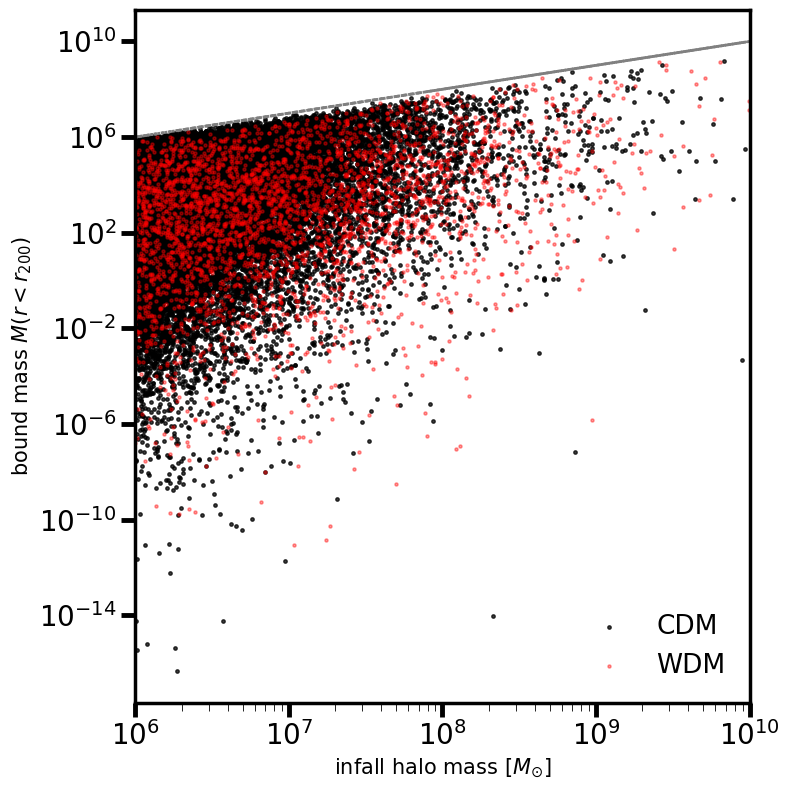

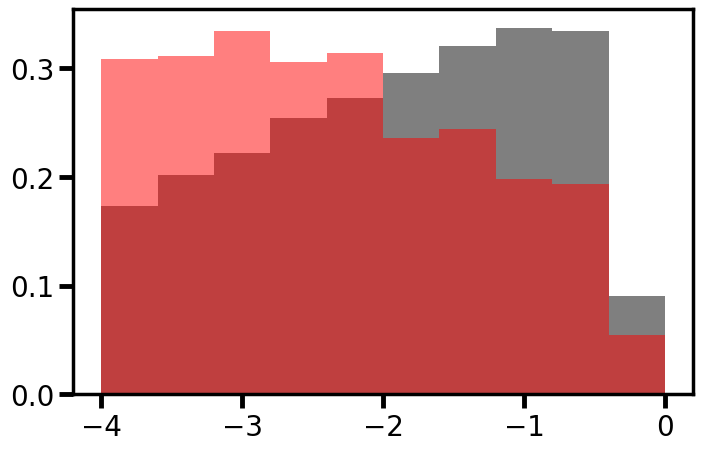

In [4]:
fig = plt.figure(1)
fig.set_size_inches(8,8)
ax = plt.subplot(111)
kwargs_plot={'alpha': 0.75,'s': 6, 'label': 'CDM'}
plot_subhalo_bound_mass(cdm_truncation_galacticus, ax=ax, kwargs_plot=kwargs_plot, color='k')
kwargs_plot={'alpha': 0.4,'s': 5, 'label': 'WDM'}
plot_subhalo_bound_mass(wdm_truncation_galacticus, ax=ax, kwargs_plot=kwargs_plot, color='r')
ax.legend(fontsize=19, frameon=False)
ax.set_ylabel('bound mass '+r'$M\left(r<r_{200}\right)$')
plt.tight_layout()

fig = plt.figure(2)
fig.set_size_inches(8,5)
plt.hist([np.log10(halo.bound_mass/halo.mass) for halo in cdm_truncation_galacticus.halos], 
         range=(-4, 0.0),bins=10,alpha=0.5,color='k',density=True)
plt.hist([np.log10(halo.bound_mass/halo.mass) for halo in wdm_truncation_galacticus.halos], 
         range=(-4, 0.0),bins=10,alpha=0.5,color='r',density=True)
#plt.savefig('./galacticus_truncation_figures/bound_mass_versus_infall_mass.pdf')

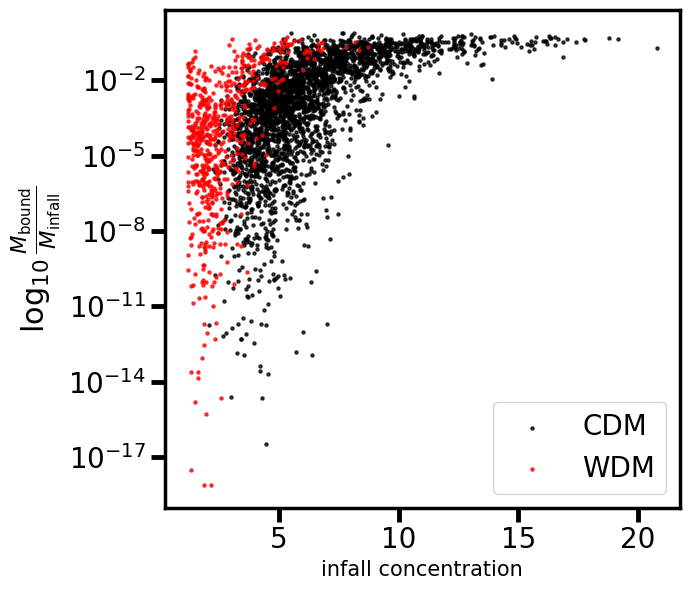

In [7]:
fig = plt.figure(1)
fig.set_size_inches(7,6)
ax = plt.subplot(111)
mass_range = [7.0, 7.5]
kwargs_plot={'alpha': 0.75, 's': 5, 'label': 'CDM'}
plot_subhalo_concentration_versus_bound_mass(cdm_truncation_galacticus, ax=ax, kwargs_plot=kwargs_plot, 
                                             color='k', log_mlow=mass_range[0], log_mhigh=mass_range[1])
kwargs_plot={'alpha': 0.75, 's': 5, 'label': 'WDM'}
plot_subhalo_concentration_versus_bound_mass(wdm_truncation_galacticus, ax=ax, kwargs_plot=kwargs_plot, 
                                             color='r', log_mlow=mass_range[0], log_mhigh=mass_range[1])
plt.tight_layout()
plt.legend(fontsize=20)
#plt.savefig('./galacticus_truncation_figures/infallc_versus_boundmass.pdf')
plt.show()



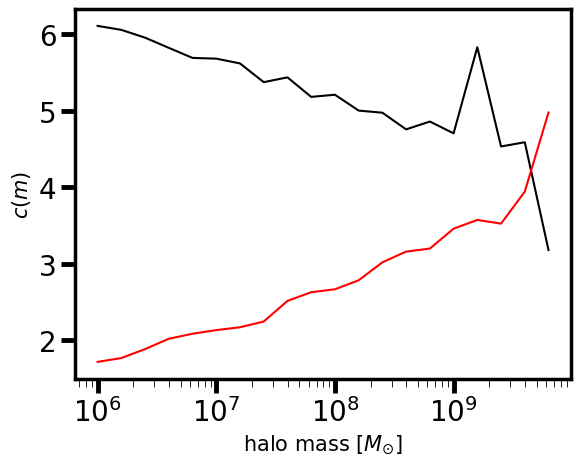

In [6]:
plt.figure(1)
ax = plt.subplot(111)
plot_concentration_mass_relation(cdm_truncation_galacticus, 0.5, ax=ax)
plot_concentration_mass_relation(wdm_truncation_galacticus, 0.5, ax=ax, color='r')